# **A PyTorch Implementation of MobileNetV2**

---



This is a PyTorch implementation of MobileNetV2 architecture as described in paper [Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification, Detection and Segmentation.](https://arxiv.org/pdf/1801.04381.pdf)

The big idea behind MobileNet is that convolutional layers, which are essential to computer vision tasks but are quite expensive to compute, can be replaced by so-called **depthwise separable convolutions**.

**MobileNetV2** uses depthwise separable convolutions, but its main building block now looks like this:

![MobileNetV2](https://machinethink.net/images/mobilenet-v2/ResidualBlock@2x.png)

There are three convolutional layers in the block. The last two are the ones we already know: a depthwise convolution that filters the inputs, followed by a 1×1 pointwise convolution layer. However, this 1×1 layer now has a different job.

In V2 the pointwise convolution makes the number of channels smaller. This is why this layer is now known as the projection layer — it projects data with a high number of dimensions (channels) into a tensor with a much lower number of dimensions.

For example, the depthwise layer may work on a tensor with 144 channels, which the projection layer will then shrink down to only 24 channels. This kind of layer is also called a bottleneck layer because it reduces the amount of data that flows through the network. (This is where the “bottleneck residual block” gets its name from: the output of each block is a bottleneck.)

The first layer is the new in the block. This is also a 1×1 convolution. Its purpose is to expand the number of channels in the data before it goes into the depthwise convolution. Hence, this expansion layer always has more output channels than input channels — it pretty much does the opposite of the projection layer.

Exactly by how much the data gets expanded is given by the expansion factor. This is one of those hyperparameters for experimenting with different architecture tradeoffs. The default expansion factor is 6.

For example, if there is a tensor with 24 channels going into a block, the expansion layer first converts this into a new tensor with 24 * 6 = 144 channels. Next, the depthwise convolution applies its filters to that 144-channel tensor. And finally, the projection layer projects the 144 filtered channels back to a smaller number, say 24 again.
![alt text](https://machinethink.net/images/mobilenet-v2/ExpandProject@2x.png)
So the input and the output of the block are low-dimensional tensors, while the filtering step that happens inside block is done on a high-dimensional tensor.

The second new thing in MobileNet V2’s building block is the residual connection. This works just like in ResNet and exists to help with the flow of gradients through the network. (The residual connection is only used when the number of channels going into the block is the same as the number of channels coming out of it, which is not always the case as every few blocks the output channels are increased.)

As usual, each layer has batch normalization and the activation function is ReLU6. However, the output of the projection layer does not have an activation function applied to it. Since this layer produces low-dimensional data, the authors of the paper found that using a non-linearity after this layer actually destroyed useful information.

# Importing Libraries
1. PyTorch & Torch Vision
2. NumPy
3. Pandas
4. OS Module
5. Pillow
6. Matplotlib

In [0]:
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary

In [2]:
# Mounting Google Drive in files directory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
# Checking if device (GPU or CPU) is available and assigning to device variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
pwd

'/content'

In [0]:
# Creating Directory "Test"
!mkdir Test

In [0]:
# Extracting Test.tar.gz (test dataset) from drive to Test direcotry

!tar -xzf "gdrive/My Drive/Colab Notebooks/datasets/ballotpaper/Test.tar-1.gz" -C "Test"

In [0]:
# Creating Directory "Train"
!mkdir Train

In [0]:
# Extracting Train.tar.gz (Train dataset) from drive to Train directory

!tar -xzf "gdrive/My Drive/Colab Notebooks/datasets/ballotpaper/Train.tar.gz" -C "Train"

In [0]:
# Path of csv file which contains image name and respective image label
train_csv_path="Train/testset.csv"
test_csv_path="Test/testset.csv"

In [0]:
# Reading csv contents using pandas
# By default it converts into pandas' dataframe

train_set=pd.read_csv(train_csv_path)
test_set=pd.read_csv(test_csv_path)

In [55]:
train_set.head()

,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10


In [0]:
# Selection of 20% random Sample from train data for validation purpose
val_set=train_set.sample(frac=0.2)

In [75]:
val_set.head()

,Data,Label
5547,668468.jpeg,42
3368,619973.jpeg,31
615,637986.jpeg,23
7112,617735.jpeg,38
5827,257344.jpeg,29


(array([200., 208., 191., 177., 206., 190., 168., 200., 194., 186.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <a list of 10 Patch objects>)

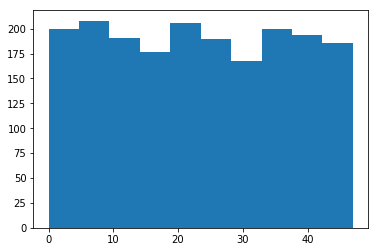

In [76]:
# Histogram Representation of Random Sample
# Viewing if validation data is stratified or not

classes = val_set["Label"]
plt.hist(classes)

In [0]:
# Removing the data from Train set that are taken for validation
# to avoid duplication and overlapping of data
train_set=train_set.drop(val_set.index)

In [16]:
# After Dropping the duplicate data, the new shape of train set
train_set.shape

(7680, 2)

In [17]:
# Checking test data shape
test_set.shape

(2609, 2)

(array([1000., 1000., 1000.,  800., 1000., 1000.,  800., 1000., 1000.,
        1000.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <a list of 10 Patch objects>)

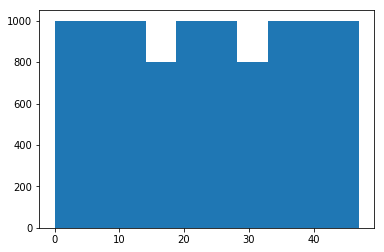

In [83]:
# Histogram Representation of train set
# Checking train set label's frequency
classes = train_set["Label"]
plt.hist(classes)

In [0]:
# Location of Images of Train & Test sets.
TRAIN_DATA_PATH="Train/testset"
TEST_DATA_PATH="Test/testset"


In [0]:
# Data Augmentation
# Some random strategy applied 
# Trying to make train data as worst as possible so it even can learn in worst case
# Normalization metrics are taken from ImageNet documentation as specified those 
# are standard and generalized

TRANSFORM_IMG_train = transforms.Compose([
    transforms.Resize((500,385)),
    torchvision.transforms.RandomRotation((-25,25)),
    torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.5, hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

TRANSFORM_IMG_test = transforms.Compose([
    transforms.Resize((500,385)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [0]:
# Class to load image and its label as tensor as per csv file information
# Converting image to tensor using PIL.Image

class Ballot_Data_Load(Dataset):
    
    def __init__(self, data_dir_path,pd_df, img_transform):
        self.data_dir_path=data_dir_path
        self.df=pd_df
        self.img_transform=img_transform
    
    # Required for shuffling    
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        df_row=self.df.iloc[index,:]
        img_name=df_row[0]
        img_path=os.path.join(self.data_dir_path,img_name)
        image=Image.open(img_path)
        image=self.img_transform(image)
        label=df_row[1]
        return (image,label)
        

In [0]:
# Object of train and test set to load tensor data of image and label
train_dataset=Ballot_Data_Load(TRAIN_DATA_PATH,train_set,TRANSFORM_IMG_train)

val_dataset=Ballot_Data_Load(TRAIN_DATA_PATH,val_set,TRANSFORM_IMG_test)

test_dataset=Ballot_Data_Load(TEST_DATA_PATH,test_set,TRANSFORM_IMG_test)


In [104]:
# Checking the train dataset
# 100th Image and its tensor
train_dataset[100][0]

tensor([[[-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124],
         [-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124],
         [-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124],
         ...,
         [-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124],
         [-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124],
         [-1.9124, -1.9124, -1.9124,  ..., -1.9124, -1.9124, -1.9124]],

        [[-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
         ...,
         [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256],
         [-1.8256, -1.8256, -1.8256,  ..., -1.8256, -1.8256, -1.8256]],

        [[-1.5953, -1.5953, -1.5953,  ..., -1.5953, -1.5953, -1.5953],
         [-1.5953, -1.5953, -1.5953,  ..., -1

In [0]:
# Creating iterator object of Dataloader for creating batchsize with shuffle and assigning 3 core
# for multiprocessing

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=3)

val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,  num_workers=3)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True,  num_workers=3)


In [106]:
train_data_loader

In [107]:
# Checking iterator object of Dataloader class 
for i in train_data_loader:
    print(i)
    break

[tensor([[[[-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665]],

         [[-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832]],

         [[-1.7522, -1.7522, -1.7522,  ..., -1.7522, -1.7522, -1.7522],
          [-1.7522, -1.7522, 

In [108]:
# Here val_data_loader contains two field ,one  is tensor with 3 channel for 32 observation which is image data
# next is label for respective 32 observation
for i in val_data_loader:
    print(i[0].shape)
    print(i[1].shape)
    print(i)
    break

torch.Size([16, 3, 500, 385])
torch.Size([16])
[tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.1462, 2.1462, 2.1462],
          [2.2489, 2.2489, 2.2489,  ..., 2.1804, 2.1804, 2.1804],
          [2.2489, 2.2489, 2.2489,  ..., 2.2147, 2.2147, 2.2147],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6

In [109]:
# Also iterator can be loaded, since DataLoader class create iterator it saves memory by loading
# only the accessed instance at memory
next(iter(test_data_loader))

[tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           ...,
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
          [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           ...,
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
          [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.64

In [0]:
# Using mobilenet_v2 pretrained architecture to train model
model=models.mobilenet_v2(pretrained=True)

In [0]:
# Modifying Fully Connected layer of built-in architecture to fit for 48 class as our problem 
# is classification into 48 classes 
model.classifier=nn.Sequential(
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1280, out_features=48, bias=True)
  )

In [112]:
# Assigning model to Gpu
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

In [0]:
# Defining epochs,loss and optimizer for training
epochs = 10
losses = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [0]:
# Function to calculate Loss and Accuracy
# This function is executed after every epoch completion,loss and accuracy are returned
# Model must be switched to evaluation mode,to stop backtracking of gradient and 
# to disable droupout and batchnormalaization
def evaluation_test(some_test):
  model.eval()
  total_loss=0
  total_correct=0
  
  for i,(img,lbl) in enumerate(some_test):
    
    correct=0
    
    img=img.to(device)
    lbl=lbl.to(device)
    
    test_forward = model.forward(img)
    test_loss = losses(test_forward,lbl).item()
    total_loss += test_loss
    
    max_val, predict_class = torch.max(test_forward.data, 1)
    correct=(predict_class == lbl).sum().item()/len(lbl)
    total_correct += correct
    
  return (total_loss/len(some_test) , (total_correct/len(some_test)*100))


  

In [117]:
model.train()
info_all=[]
for epoch in range(epochs):
  train_correct=0
  for i, (images, labels) in enumerate(train_data_loader):


    correct=0
    # Clear the gradients
    optimizer.zero_grad()
    
    # Assigning data and labels to device
    images=images.to(device)
    labels=labels.to(device)

    # Forward propagation 
    outputs = model.forward(images)      


    # Calculating loss with softmax to obtain cross entropy loss
    loss = losses(outputs, labels)

    # Backward propation
    loss.backward()

    # Updating gradients
    optimizer.step()

  
  # Looking for loss and accuracy in entire validation set and Train set
  train_loss,train_acc = evaluation_test(train_data_loader)
  val_loss,val_acc = evaluation_test(val_data_loader)

  # Creating a list with info of training and validation,loss and accuracy for each epoch
  # useful for plotting the curve of epoch vs trainingloss/training accuracy
 
  for_plot={"epoch":epoch+1,"train_loss":train_loss,"train_accuracy":train_acc,
            "val_loss":val_loss,"val_accuracy":val_acc}
  info_all.append(for_plot) 
  
  # Switching back train mode,as on evaluation of loss & accuracy, it was
  # switched to evaluation mode
  model.train()
  print('Epoch [{}/{}], TrainingLoss: {:.4f}, TrainingAccuracy: {:.2f}%,ValLoss:{:.4f},ValAccuracy:{:.2f}%'
    .format(epoch + 1, epochs,train_loss,train_acc,val_loss,val_acc))#Train the model


Epoch [1/10], TrainingLoss: 0.0804, TrainingAccuracy: 99.68%,ValLoss:0.0754,ValAccuracy:99.43%
Epoch [2/10], TrainingLoss: 0.0159, TrainingAccuracy: 99.91%,ValLoss:0.0116,ValAccuracy:99.90%
Epoch [3/10], TrainingLoss: 0.0077, TrainingAccuracy: 99.94%,ValLoss:0.0110,ValAccuracy:99.84%
Epoch [4/10], TrainingLoss: 0.0048, TrainingAccuracy: 99.98%,ValLoss:0.0024,ValAccuracy:100.00%
Epoch [5/10], TrainingLoss: 0.0052, TrainingAccuracy: 99.93%,ValLoss:0.0027,ValAccuracy:99.90%
Epoch [6/10], TrainingLoss: 0.0148, TrainingAccuracy: 99.77%,ValLoss:0.0200,ValAccuracy:99.64%
Epoch [7/10], TrainingLoss: 0.0017, TrainingAccuracy: 100.00%,ValLoss:0.0013,ValAccuracy:99.95%
Epoch [8/10], TrainingLoss: 0.0015, TrainingAccuracy: 99.99%,ValLoss:0.0003,ValAccuracy:100.00%
Epoch [9/10], TrainingLoss: 0.0062, TrainingAccuracy: 99.96%,ValLoss:0.0011,ValAccuracy:100.00%
Epoch [10/10], TrainingLoss: 0.0101, TrainingAccuracy: 99.84%,ValLoss:0.0043,ValAccuracy:100.00%


In [0]:
# Creating a checkpoint dictionary, saving model and its state and optimizer state as well.
# Saving dictionary to file , extension .pth,.pt,.pkl
checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [0]:
# Loading saved model state to my_model
# Creating model from saved state and switching it to evalulation mode for inference
def load_checkpoint(model_path):
  checkpoint=torch.load(model_path)
  model=checkpoint["model"]
  
  model.load_state_dict(checkpoint["state_dict"])
  
  for parameter in model.parameters():
    parameter.requires_grad=False

  model.eval()
  return model

my_model=load_checkpoint("checkpoint.pth")

In [121]:
my_model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

In [122]:

# Test set accuracy
correct=0
for i,(imag,label) in enumerate(test_data_loader):
  image=imag.to(device)
  label=label.to(device)
  output=my_model.forward(image)
  max_val,prediction=torch.max(output.data,1)
  correct+=(((prediction==label).sum().item())/len(label))
print(correct/len(test_data_loader)*100)
  

100.0


In [0]:
# Extracting information of training and val set from info_all list of dict
# It contain trains and test loss/accuracy for each epoch
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]
for i in info_all:
  val_loss.append(i["val_loss"])
  val_acc.append(i["val_accuracy"])
  train_loss.append(i["train_loss"])
  train_acc.append(i["train_accuracy"])
 
  

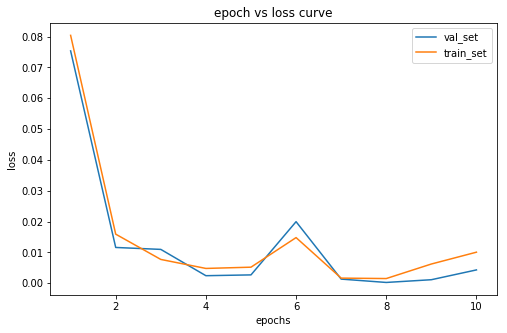

In [124]:
# Graph Showing epoch vs loss. 
plt.figure(figsize=(8,5))
plt.title("epoch vs loss curve")
plt.plot(range(1,11),val_loss,label="val_set")
plt.plot(range(1,11),train_loss,label="train_set")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

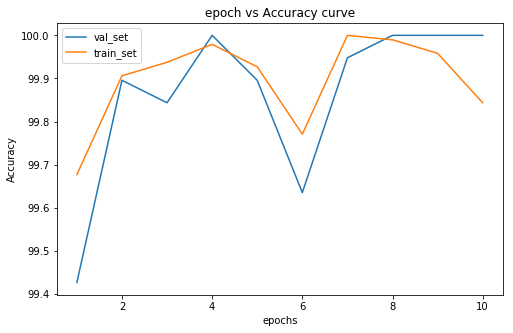

In [125]:
# Graph showing epoch vs Accuracy
plt.figure(figsize=(8,5))
plt.title("epoch vs Accuracy curve")
plt.plot(range(1,11),val_acc,label="val_set")
plt.plot(range(1,11),train_acc,label="train_set")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [126]:
summary(my_model,input_size=(3,500,385))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 250, 193]             864
       BatchNorm2d-2         [-1, 32, 250, 193]              64
             ReLU6-3         [-1, 32, 250, 193]               0
            Conv2d-4         [-1, 32, 250, 193]             288
       BatchNorm2d-5         [-1, 32, 250, 193]              64
             ReLU6-6         [-1, 32, 250, 193]               0
            Conv2d-7         [-1, 16, 250, 193]             512
       BatchNorm2d-8         [-1, 16, 250, 193]              32
  InvertedResidual-9         [-1, 16, 250, 193]               0
           Conv2d-10         [-1, 96, 250, 193]           1,536
      BatchNorm2d-11         [-1, 96, 250, 193]             192
            ReLU6-12         [-1, 96, 250, 193]               0
           Conv2d-13          [-1, 96, 125, 97]             864
      BatchNorm2d-14          [-1, 96, 